# One more data analysis about the COVID-19, but normalized...

## Table of contents

- [Introduction](#Introduction)
- [Global data](#Global-data)
    * [Confirmed cases](#Confirmed-cases)
    * [Death cases](#Death-cases)
    * [Mortality rate](#Mortality-rate)
    * [Recovered cases](#Recovered-cases)
- [Report by country](#Report-by-country)

## Introduction

I coded this in order to follow figures about the COVID-19, for curiosity, without any goal else.

It would be very useful and interesting to know :
* the number of tests in each country (maybe the confirmed rate is underestimated) ;
* the fiability of figures of death (countries may hide some death).

I am not a data scientist, thanks for any tip you can give me to improve this code.

Take care,

Yann Marsaud

### What is COVID-19 ?

From the **World Health Organization** : https://www.who.int/news-room/q-a-detail/q-a-coronaviruses

From the **Institut Pasteur** : https://www.pasteur.fr/en/medical-center/disease-sheets/covid-19-disease-novel-coronavirus

### Sources

Data of cases provided by https://github.com/CSSEGISandData/COVID-19

Global data (data/population.csv) from https://data.worldbank.org/indicator/SP.POP.TOTL

In [71]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
#import psutil
from IPython.core.display import display, HTML, Markdown
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
%matplotlib inline

In [72]:
## Functions to clean and prepare data
######################################
## returns a dataframe with the sum of cases for the country_str from the data source src_data
## Country/Region is the new index of this dataframe (=country_str)
def sum_cases(src_data,country_str):
    multi = src_data[src_data["Country/Region"] == country_str]
    multi = multi.groupby(multi["Country/Region"]).sum()
    return multi

## Returns a dataframe with the selected 'countries' and the 'countries_group' 
 # (countries with more than one province) 
 # Extra : prepares timeseries
 # Index of the returned dataframe : 'Country/Region'
def prepare_data(data,countries,countries_group):
    # Loads data from countries ignoring provinces
    data_selected = data[data["Country/Region"].isin(countries) & data["Province/State"].isnull() ]
    data_selected = data_selected.set_index('Country/Region')
    # Agregates country with provinces in the final result
    for c in countries_group:
        data_selected = pd.concat([sum_cases(data,c),data_selected])
    # deleting useless fields
    data_selected = data_selected.drop(["Province/State","Lat","Long"],axis=1) 
    data_selected = data_selected.transpose()
    data_selected.index = pd.to_datetime(data_selected.index)
    data_selected = data_selected.transpose()
    return data_selected

## Returns data normalized to convert data per 10^n inhabitants and transposes it
# data_selected's index is 'Country/Region'
def normalize(data_selected,n):
    data_norm = data_selected.copy()
    # merge data with country names
    data_norm = data_norm.join(population.set_index('Country/Region'))
    data_norm["Population"] = data_norm["Population"] / 10**n
    data_norm = data_norm.div(data_norm["Population"],axis=0)
    data_norm = data_norm.drop(["Population"],axis=1)
    data_norm = data_norm.transpose()
    data_norm = index_to_time(data_norm)
    return data_norm

def index_to_time(df,name='Date'):
    df.index = pd.to_datetime(df.index)
    df.index = df.index.rename(name)
    return df

# Deletes the first values while they equal 0
def shift_to_first_case(df,country):
    shift = df[country]
    shift = shift.dropna(axis=0,how='all')
    shift = shift[shift.values != 0  ]
    shift = shift.reset_index()
    shift = shift.drop(["Date"],axis=1)
    return shift
    
## Prepares and plots with plotly a dataframe with timeseries for index
# df : a dataframe
# meta : contains 'title' and 'filename'
def timeseries_with_plotly(df,meta):
    df = df.reset_index()
    if 'x' not in meta: meta['x'] = 'Date'
    df = df.melt(id_vars=meta['x'],
                 value_name=meta['y'],
                 var_name=meta['series'])
    title = meta['title']
    w = 800
    color_seq = px.colors.qualitative.Plotly
    if 'subtitle' in meta: title += "<br>"+meta['subtitle']
    if 'plot_type' in meta and meta['plot_type'] == 'bar':
         fig = px.bar(df, x=meta['x'], y=meta['y'], 
                      color=meta['series'],title=title,width=w,
                      color_discrete_sequence=color_seq,)
    else: fig = px.line(df, x=meta['x'],y=meta['y'], 
                  color=meta['series'],title=title,width=w,
                  color_discrete_sequence=color_seq,
                  render_mode="svg",)
    fig.update_layout(autosize=True,)
    #fig.write_image("report/"+meta['filename']+".png")
    fig.show()
    
# plot all countries from the first case
def firstcase_compare_plot(df,case_type):
    all_pays = sorted(pays + to_agregate)
    from_first = shift_to_first_case(df,all_pays[0])

    for country in all_pays[1:]:
        other = shift_to_first_case(df,country)
        from_first = from_first.merge(other,how='outer',left_on=from_first.index,right_on=other.index)
        from_first = from_first.drop(["key_0"],axis=1)
    meta = prepare_metadata(case_type)
    meta['x'] = 'Day'
    from_first.index = from_first.index.rename(meta['x'])
    meta['subtitle'] = 'Comparison from Day 0 : the first case'
    #ax = from_first.plot(title=title)
    #ax.set_xlabel("Day")
    #ax.set_ylabel("Normalized value")
    timeseries_with_plotly(from_first,meta)
    
## returns an array with automatic title and automatic file name
# title_type : one value amongst 'confirmed', 'recovered', 'death', 'mortality'
# time : timestamp
# Returns : an array with 'title', 'filename'
def prepare_metadata(title_type):
    norm_format =  'cases per '+'{:,}'.format(10**n)+' people'
    if title_type in(['Confirmed','Recovered',
                        'Active','Death']):
        title = f"{title_type} {norm_format}"
        y = 'Cases'
        series = 'Country/Region'
    elif title_type in(['Mortality','Recovery']):
        title = f"{title_type} rate (per 100 confirmed)"
        y = 'Cases (%)'
        series = 'Country/Region'
    else: title = ""
    #updated = "Last updated : " + time.strftime("%Y/%m/%d") 
    #filename = "covid19_"+title_type+"_"+time.strftime("%Y_%m_%d")
    return {'title':title,'y':y,'series':series}

def meta_to_html(meta):
    display(HTML("<h4>"+meta['title']+"</h4><h5>"+meta['updated']+"</h5>"))
    
# Basis of normalization : per 10**n inhabitants
n = 3
# Path of imported data
online = True
def get_path():
    if online: return 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
    else: return '../data/COVID-19/csse_covid_19_data/csse_covid_19_time_series/'

In [73]:
## Geography
############
# importing data from population, updates data structure
population = pd.read_csv("data/population.csv",header=2)
population = population[["Country Name","2018"]]
population = population.rename(columns={"2018":"Population","Country Name":"Country/Region"}) 
# compatibility of names of country
population.at[249,'Country/Region']  = 'US' 
# selecting countries ignoring provinces
pays = ['France','Argentina','Chile','Italy','US','Spain','United Kingdom','Germany','Brazil']
# selecting countries with provinces
to_agregate = ['Canada','China'] 
# filtering selected countries
population = population[population["Country/Region"].isin(pays) | population["Country/Region"].isin(to_agregate)] 
#population.head()

## Global data

### Confirmed cases

In [74]:
data_confirmed = pd.read_csv(get_path()+"time_series_covid19_confirmed_global.csv")
confirmed = prepare_data(data_confirmed,pays,to_agregate)
#confirmed

#### Raw number of cases

In [75]:
confirmed.transpose().tail(1)

Country/Region,China,Canada,Argentina,Brazil,Chile,France,Germany,Italy,Spain,United Kingdom,US
2020-04-22,83868,41648,3144,45757,11296,155860,150648,187327,208389,133495,839675


#### Normalization of cases for comparison

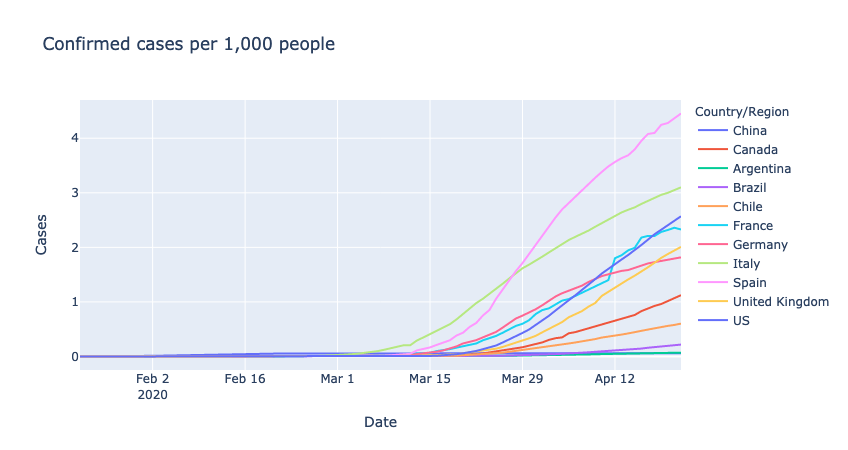

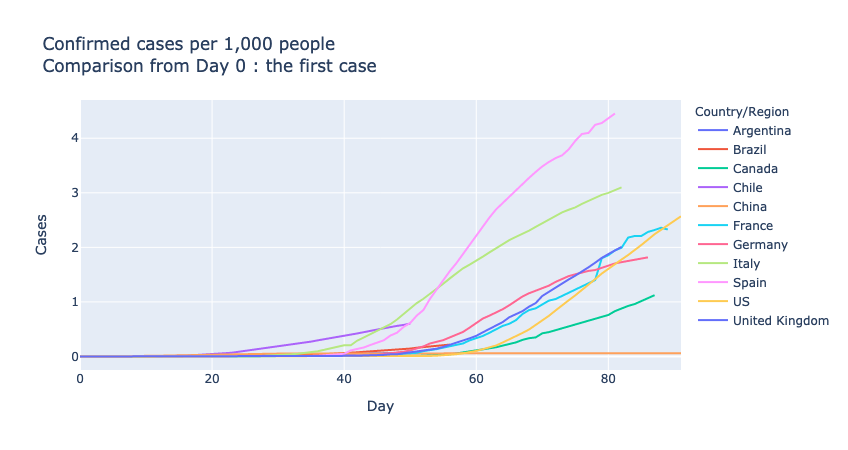

In [76]:
time = confirmed.columns[-1]
meta = prepare_metadata('Confirmed')
#meta_to_html(meta)
confirmed_norm = normalize(confirmed,n)
#confirmed_norm.plot(title=title)
#plot_with_plotly(confirmed_norm,meta)
timeseries_with_plotly(confirmed_norm,meta)
firstcase_compare_plot(confirmed_norm,'Confirmed')

### Death cases

In [77]:
data = pd.read_csv(get_path()+"time_series_covid19_deaths_global.csv")
death = prepare_data(data,pays,to_agregate)

#### Raw number of cases

In [78]:
death.transpose().tail(1)

Country/Region,China,Canada,Argentina,Brazil,Chile,France,Germany,Italy,Spain,United Kingdom,US
2020-04-22,4636,2075,152,2906,160,21340,5279,25085,21717,18100,46583


<!---
### Normalization of cases for comparison
-->

In [79]:
time = death.columns[-1]
#meta = prepare_metadata('death',time)
#meta_to_html(meta)
death_norm = normalize(death,n) 
#death_norm.plot(title=title) 

#### Mortality rate
This rate is death/confirmed, per 100 confirmed.

In [80]:
death_rate =  death_norm / confirmed_norm * 100
death_rate = index_to_time(death_rate)

##### Last mortality rates

In [81]:
death_rate.tail(1)

Country/Region,China,Canada,Argentina,Brazil,Chile,France,Germany,Italy,Spain,United Kingdom,US
Date,,,,,,,,,,,
2020-04-22,5.527734,4.982232,4.834606,6.350941,1.416431,13.691775,3.504195,13.391022,10.421375,13.55856,5.547742


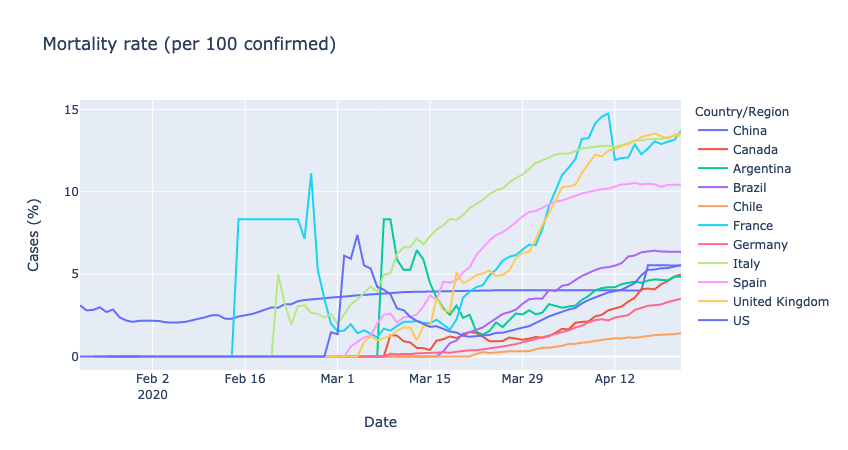

In [82]:
time = death_rate.index[-1]
meta = prepare_metadata('Mortality')
#meta_to_html(meta)
#death_rate.plot(title = title)
#plot_with_plotly(death_rate,meta)
timeseries_with_plotly(death_rate,meta)

### Recovered cases

In [83]:
data_recovered = pd.read_csv(get_path()+"time_series_covid19_recovered_global.csv")
recovered = prepare_data(data_recovered,pays,to_agregate)

#### Raw number of cases

In [84]:
recovered.transpose().tail(1)

Country/Region,China,Canada,Argentina,Brazil,Chile,France,Germany,Italy,Spain,United Kingdom,US
2020-04-22,77861,14454,872,25318,5386,40657,99400,54543,85915,0,77366


#### Recovery rate
This rate is recovered/confirmed, per 100 confirmed.

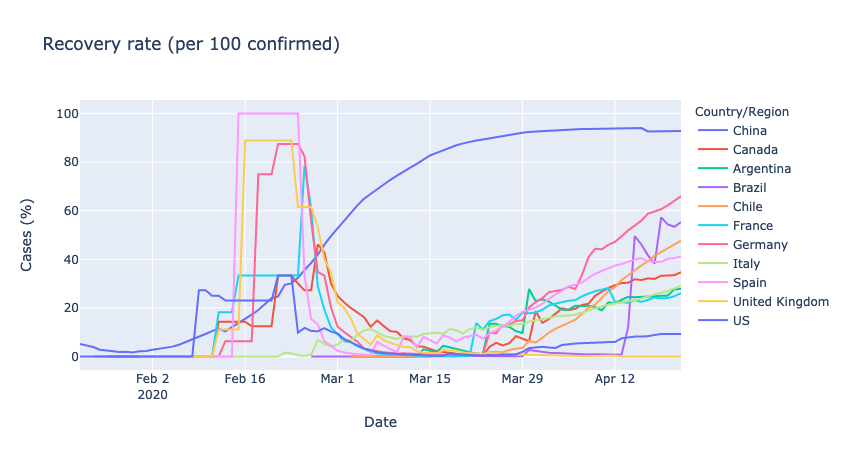

In [85]:
recovered_norm = normalize(recovered,n) 
recov_rate = recovered_norm / confirmed_norm * 100
recov_rate = index_to_time(recov_rate)
meta = prepare_metadata('Recovery')
#meta_to_html(meta)
#recovered_norm.plot(title=title) 
#plot_with_plotly(recov_rate,meta)
timeseries_with_plotly(recov_rate,meta)

### Active cases
Difference between confirmed cases and sum of death+recovered

#### Raw number of cases

In [86]:
active = confirmed - (recovered+death)
active.transpose().tail(1)

Country/Region,China,Canada,Argentina,Brazil,Chile,France,Germany,Italy,Spain,United Kingdom,US
2020-04-22,1371,25119,2120,17533,5750,93863,45969,107699,100757,115395,715726


#### Normalization of cases for comparison

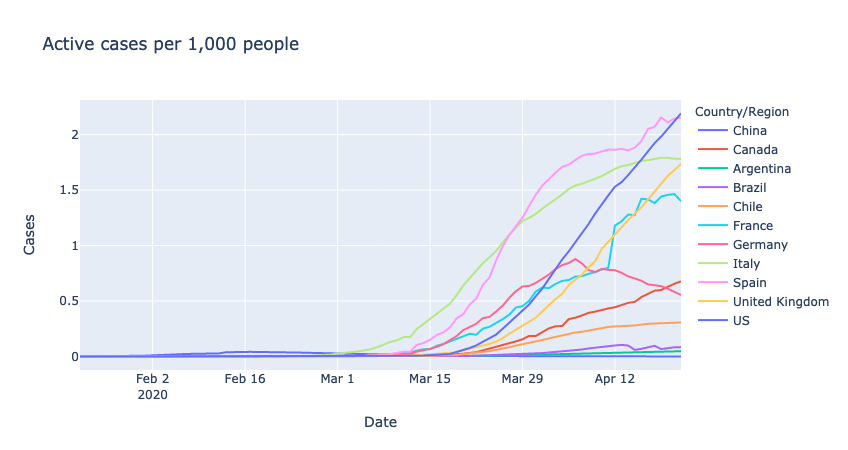

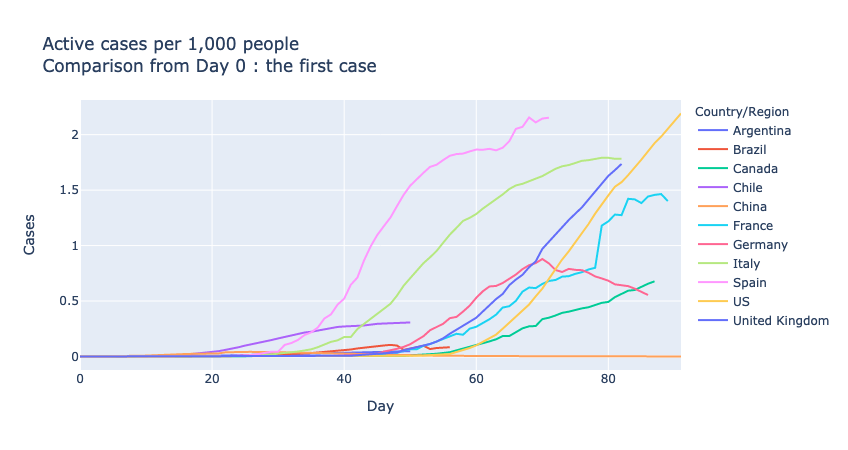

In [87]:
meta = prepare_metadata('Active')
#meta_to_html(meta)
active_norm = normalize(active,n) 
#death_norm.plot(title=title) 
#plot_with_plotly(active_norm,meta)
timeseries_with_plotly(active_norm,meta)
firstcase_compare_plot(active_norm,'Active')

## Report by country
Please choose a country below :

In [88]:
@interact
def analysis_by_country(country=sorted(pays+to_agregate)):
    # preparing data
    rates_by_country = pd.merge(death_rate[country],recov_rate[country],on=death_rate.index)
    rates_by_country = rates_by_country.rename(columns={"key_0":"Date",country+"_x":"Mortality", country+"_y":"Recovery"})
    rates_by_country = rates_by_country.set_index('Date')
    rates_by_country['Active'] = 100 -(rates_by_country['Mortality']+rates_by_country['Recovery'])
    # selecting rows with 1 or more cases
    rates_by_country = rates_by_country.dropna(axis=0,how='all')
    rates_by_country = rates_by_country[rates_by_country.values.sum(axis=1) != 0  ]
    first_case = rates_by_country.head(1).index[0]
    rates_by_country = rates_by_country[['Mortality','Active','Recovery']]
    # general display
    display(HTML('<h2>'+country+'</h2><hr>'))
    gen_md = "**First case** : " + first_case.strftime("%Y/%m/%d")+"\n\n"
    gen_md += "|Confirmed cases|Death cases|Recovered cases|Population|\n"
    gen_md += "|:---:|:---:|:---:|:---:|\n"
    pop = '{:,}'.format(population.loc[population["Country/Region"] == country,'Population'].iat[0])
    gen_md += f"|{confirmed.loc[country][-1]}|{death.loc[country][-1]}|{recovered.loc[country][-1]}|{pop}|\n\n"
    gen_md += "*Last updated* : "+confirmed.loc[country].index[-1].strftime("%Y/%m/%d")
    display(Markdown(gen_md))
    # rates display
    display(Markdown("### Rates (en % of confirmed)"))
    display(Markdown('#### Last rates'))
    display(rates_by_country.tail(1))
    
    meta = {'title':'Time series of rates : '+country,
           'y':'Cases per confirmed (%)',
           'series':'Rate'}
    timeseries_with_plotly(rates_by_country,meta)
    # distribution display
    display(Markdown("### Distribution of cases (normalized)"))
    dist_by_country = pd.merge(death_norm[country],recovered_norm[country],on=death_norm.index)
    dist_by_country = dist_by_country.merge(active_norm[country],left_on='key_0',right_on=active_norm.index)
    dist_by_country = dist_by_country.rename(columns={country+"_x":"Dead", 
                                                      country+"_y":"Recovered",
                                                     country:"Active",
                                                     "key_0":"Date"})
    dist_by_country = dist_by_country.set_index('Date')
    # selecting rows with 1 or more cases
    dist_by_country = dist_by_country[dist_by_country.values.sum(axis=1) != 0  ]
    dist_by_country = dist_by_country[['Dead','Active','Recovered']]
    display(HTML('Last normalized distribution of cases in '+country+' per '+'{:,}'.format(10**n)+' people'))
    display(dist_by_country.tail(1))
    #df = dist_by_country.reset_index()
    meta['y'] = 'Cases per '+'{:,}'.format(10**n)+' people'
    meta['title'] = 'Distribution of cases in '+country 
    meta['series'] = 'Type of case'
    meta['plot_type'] = 'bar'
    timeseries_with_plotly(dist_by_country,meta)

interactive(children=(Dropdown(description='country', options=('Argentina', 'Brazil', 'Canada', 'Chile', 'Chin…